# NLP Healthcare classifier 

# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns

C:\Users\Ashish\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Ashish\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ashish\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ashish\Anaconda3\lib\site-packages\tensorflow\python\framew

# Importing Training Dataset

In [2]:
df = pd.read_csv('train.csv',encoding= 'unicode_escape')
df.head()

,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT,Patient_Tag
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,6/15/2016,13:58:00,6/15/2016 23:28,Epstein,I don't disagree with you in principle. I'm ju...,0
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,5/7/2016,0.820833333,42498.21667,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,4/14/2016,15:00:38,4/15/2016 0:30,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,6/18/2016,20:46:00,6/19/2016 6:16,Bulaemia,I am 17 and I have been throwing up for about ...,1
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,6/15/2016,3:26:00,6/15/2016 12:56,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0


# Data Description

From above data, It can be said that, the data provide the message of various stakeholders of healthcare along with the "title" and their "data" and "time" in 2 format i.e. "ET" and "GMT", it also provide source of message and link along with the host. 

But the text in host column is a subset of the text in Link column. So it doesn't add any extra information to predict the patient_Tag

So the Host column can be droped and it will be dropped it in later steps.

# Data Visualization, Data Analysis and Feature Engineering

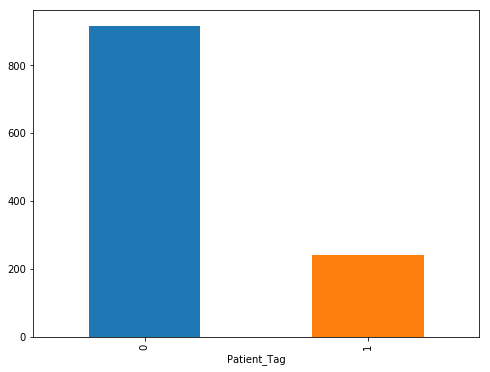

In [3]:
fig = plt.figure(figsize=(8,6))
df.groupby('Patient_Tag').TRANS_CONV_TEXT.count().plot.bar(ylim=0)
plt.show(1)

So data is biased towards 'Patient_Tag' = 0

In [4]:
df.columns

Index(['Source', 'Host', 'Link', 'Date(ET)', 'Time(ET)', 'time(GMT)', 'Title',
       'TRANS_CONV_TEXT', 'Patient_Tag'],
      dtype='object')

In [5]:
df.isnull().sum()

Source               0
Host                59
Link                 0
Date(ET)             0
Time(ET)             0
time(GMT)          161
Title              216
TRANS_CONV_TEXT      1
Patient_Tag          0
dtype: int64

So there are Null values in the dataset i.e in column 'Host', 'time(GMT)', 'Title'and 'TRANS_CONV_TEXT'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 9 columns):
Source             1157 non-null object
Host               1098 non-null object
Link               1157 non-null object
Date(ET)           1157 non-null object
Time(ET)           1157 non-null object
time(GMT)          996 non-null object
Title              941 non-null object
TRANS_CONV_TEXT    1156 non-null object
Patient_Tag        1157 non-null int64
dtypes: int64(1), object(8)
memory usage: 81.4+ KB


It is also clear that date and time columns are of object type so they must be converted into datatime format. 

Since 'Data(ET)' column contains the date in 3 format of strings i.e. '%m/%d/%Y' , '%d-%b-%y' , '%d-%m-%Y' and they all are to be converted in to same format of date time.

In [7]:
for i in range(0,1157):
    if ('/' in df['Date(ET)'][i]):
        df['Date(ET)'][i] = pd.to_datetime(df['Date(ET)'][i], format='%m/%d/%Y')
    elif(('-' in df['Date(ET)'][i]) and (('Jan' in df['Date(ET)'][i]) or ('Feb' in df['Date(ET)'][i]) or ('Mar' in df['Date(ET)'][i]) or ('Apr' in df['Date(ET)'][i]) or ('May' in df['Date(ET)'][i]) or ('Jun' in df['Date(ET)'][i]) or ('Jul' in df['Date(ET)'][i]) or ('Aug' in df['Date(ET)'][i]) or ('Sep' in df['Date(ET)'][i]) or ('Oct' in df['Date(ET)'][i]) or ('Nov' in df['Date(ET)'][i]) or ('Dec' in df['Date(ET)'][i]))):
        df['Date(ET)'][i] = pd.to_datetime(df['Date(ET)'][i], format='%d-%b-%y')
    else:
        df['Date(ET)'][i] = pd.to_datetime(df['Date(ET)'][i], format='%d-%m-%Y')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [8]:
df['Date(ET)'].head()

0    2016-06-15 00:00:00
1    2016-05-07 00:00:00
2    2016-04-14 00:00:00
3    2016-06-18 00:00:00
4    2016-06-15 00:00:00
Name: Date(ET), dtype: object

So it can be seen that the format and data type of the 'Date(ET)' is changed with proper date and it's format but time is 00:00:00 in all columns and that is because the time is contained in Time(ET) and the time in this column is made to be 00:00:00.

In Similar way the 'Time(ET)' column can be updated because it also have time in different format of strings. 

In [9]:
for i in range(0,1157):
    if (('AM' in df['Time(ET)'][i]) or ('PM' in df['Time(ET)'][i])):
        df['Time(ET)'][i] = pd.to_datetime(df['Time(ET)'][i], format='%I:%M %p')
    elif('.' in df['Time(ET)'][i]):
        df['Time(ET)'][i] = pd.to_datetime('0:0:0', format='%H:%M:%S')
    else:
        df['Time(ET)'][i] = pd.to_datetime(df['Time(ET)'][i], format='%H:%M:%S')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df['Time(ET)'].head()

0    1900-01-01 13:58:00
1    1900-01-01 00:00:00
2    1900-01-01 15:00:38
3    1900-01-01 20:46:00
4    1900-01-01 03:26:00
Name: Time(ET), dtype: object

So from above cells it can be seen that the updated 'Date(ET)' and 'Time(ET)' columns have date and time respectively(in ET Format) with time and date are set to default repectively. 

So the date from 'Date(ET)' and time from 'Time(ET)'can be used to make a new column which will be having the date and time in format of '%Y-%m-%d %H:%M:%S' in 1 column for Estern Time(ET)

In [11]:
df['Date_Time_ET'] = np.nan
for i in range(0,1157):
    a , b = str(df['Date(ET)'][i]).split(' ')
    c , d = str(df['Time(ET)'][i]).split(' ')
    df['Date_Time_ET'][i] = pd.to_datetime(a + ' ' + d , format='%Y-%m-%d %H:%M:%S')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
df['Date_Time_ET'].head()

0    2016-06-15 13:58:00
1    2016-05-07 00:00:00
2    2016-04-14 15:00:38
3    2016-06-18 20:46:00
4    2016-06-15 03:26:00
Name: Date_Time_ET, dtype: object

So it can be seen that now Date and time for Eastern Time(ET) are in one column i.e. 'Date_Time_ET'

Now we have some missing value for GMT Format of date time, but it doesn't create any problem because we have all value for ET format and we can easily calculate the GMT date time using ET datetime in the following cell.

In [13]:
df['Date_Time_GMT'] = np.nan
for i in range(0,1157):
    
    Time_ET = pd.Timestamp(str(df['Date_Time_ET'][i]), tz='US/Eastern')

    df['Date_Time_GMT'][i] = Time_ET.tz_convert('UTC')  

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
df.head()

,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT,Patient_Tag,Date_Time_ET,Date_Time_GMT
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,2016-06-15 00:00:00,1900-01-01 13:58:00,6/15/2016 23:28,Epstein,I don't disagree with you in principle. I'm ju...,0,2016-06-15 13:58:00,2016-06-15 17:58:00+00:00
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,2016-05-07 00:00:00,1900-01-01 00:00:00,42498.21667,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1,2016-05-07 00:00:00,2016-05-07 04:00:00+00:00
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,2016-04-14 00:00:00,1900-01-01 15:00:38,4/15/2016 0:30,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0,2016-04-14 15:00:38,2016-04-14 19:00:38+00:00
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,2016-06-18 00:00:00,1900-01-01 20:46:00,6/19/2016 6:16,Bulaemia,I am 17 and I have been throwing up for about ...,1,2016-06-18 20:46:00,2016-06-19 00:46:00+00:00
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,2016-06-15 00:00:00,1900-01-01 03:26:00,6/15/2016 12:56,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0,2016-06-15 03:26:00,2016-06-15 07:26:00+00:00


Now it can be seen from this step that we have 2 columns i.e. "Date_Time_ET" and "Date_Time_GMT" in our data frame "df" which contains the Datetime in ET and GMT format respectively.  

So the columns ['Date(ET)', 'Time(ET)', 'time(GMT)'] can be dropped.

In [15]:
df = df.drop(['Date(ET)', 'Time(ET)', 'time(GMT)'], axis =  1)

In [16]:
df.head()

,Source,Host,Link,Title,TRANS_CONV_TEXT,Patient_Tag,Date_Time_ET,Date_Time_GMT
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,Epstein,I don't disagree with you in principle. I'm ju...,0,2016-06-15 13:58:00,2016-06-15 17:58:00+00:00
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1,2016-05-07 00:00:00,2016-05-07 04:00:00+00:00
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0,2016-04-14 15:00:38,2016-04-14 19:00:38+00:00
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,Bulaemia,I am 17 and I have been throwing up for about ...,1,2016-06-18 20:46:00,2016-06-19 00:46:00+00:00
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0,2016-06-15 03:26:00,2016-06-15 07:26:00+00:00


Now it is well known that the Date time data is precious because it can create many features from just one datetime feature which have higher correlation from the output to be predicted.

So let's do some feature engineering to create some more useful features. 

In [17]:
df['Date_Time_ET_day'] = pd.DatetimeIndex(df['Date_Time_ET']).day
df['Date_Time_ET_month'] = pd.DatetimeIndex(df['Date_Time_ET']).month
df['Date_Time_ET_hour'] = pd.DatetimeIndex(df['Date_Time_ET']).hour
df['Date_Time_ET_minute'] = pd.DatetimeIndex(df['Date_Time_ET']).minute
df['Date_Time_ET_second'] = pd.DatetimeIndex(df['Date_Time_ET']).second
df['Date_Time_ET_dayofweek'] = pd.DatetimeIndex(df['Date_Time_ET']).dayofweek

In [18]:
df['Date_Time_GMT_day'] = pd.DatetimeIndex(df['Date_Time_GMT']).day
df['Date_Time_GMT_month'] = pd.DatetimeIndex(df['Date_Time_GMT']).month
df['Date_Time_GMT_hour'] = pd.DatetimeIndex(df['Date_Time_GMT']).hour
df['Date_Time_GMT_minute'] = pd.DatetimeIndex(df['Date_Time_GMT']).minute
df['Date_Time_GMT_second'] = pd.DatetimeIndex(df['Date_Time_GMT']).second
df['Date_Time_GMT_dayofweek'] = pd.DatetimeIndex(df['Date_Time_GMT']).dayofweek

In [19]:
df.head()

,Source,Host,Link,Title,TRANS_CONV_TEXT,Patient_Tag,Date_Time_ET,Date_Time_GMT,Date_Time_ET_day,Date_Time_ET_month,Date_Time_ET_hour,Date_Time_ET_minute,Date_Time_ET_second,Date_Time_ET_dayofweek,Date_Time_GMT_day,Date_Time_GMT_month,Date_Time_GMT_hour,Date_Time_GMT_minute,Date_Time_GMT_second,Date_Time_GMT_dayofweek
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,Epstein,I don't disagree with you in principle. I'm ju...,0,2016-06-15 13:58:00,2016-06-15 17:58:00+00:00,15,6,13,58,0,2,15,6,17,58,0,2
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1,2016-05-07 00:00:00,2016-05-07 04:00:00+00:00,7,5,0,0,0,5,7,5,4,0,0,5
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0,2016-04-14 15:00:38,2016-04-14 19:00:38+00:00,14,4,15,0,38,3,14,4,19,0,38,3
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,Bulaemia,I am 17 and I have been throwing up for about ...,1,2016-06-18 20:46:00,2016-06-19 00:46:00+00:00,18,6,20,46,0,5,19,6,0,46,0,6
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0,2016-06-15 03:26:00,2016-06-15 07:26:00+00:00,15,6,3,26,0,2,15,6,7,26,0,2


Now as ['Date_Time_ET', 'Date_Time_GMT'], these columns are used to generate the useful features so now we can drop them from the dataframe "df".

In [20]:
df = df.drop(['Date_Time_ET', 'Date_Time_GMT'], axis =  1)

As data indicates that "Host" feature does not provide any extra knowledge so we can drop it(As Discussed in the above cells). 

In [21]:
df = df.drop(['Host'], axis =  1)

In [22]:
df.head()

,Source,Link,Title,TRANS_CONV_TEXT,Patient_Tag,Date_Time_ET_day,Date_Time_ET_month,Date_Time_ET_hour,Date_Time_ET_minute,Date_Time_ET_second,Date_Time_ET_dayofweek,Date_Time_GMT_day,Date_Time_GMT_month,Date_Time_GMT_hour,Date_Time_GMT_minute,Date_Time_GMT_second,Date_Time_GMT_dayofweek
0,FORUMS,http://cafepharma.com/boards/threads/epstein.5...,Epstein,I don't disagree with you in principle. I'm ju...,0,15,6,13,58,0,2,15,6,17,58,0,2
1,FORUMS,http://www.patient.co.uk/forums/discuss/enlarg...,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1,7,5,0,0,0,5,7,5,4,0,0,5
2,BLOG,http://abcnewsradioonline.com/entertainment-ne...,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0,14,4,15,0,38,3,14,4,19,0,38,3
3,FORUMS,http://www.cancer-forums.net/viewtopic.php?f=1...,Bulaemia,I am 17 and I have been throwing up for about ...,1,18,6,20,46,0,5,19,6,0,46,0,6
4,FORUMS,http://www.diyaudio.com/forums/lounge/292252-d...,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0,15,6,3,26,0,2,15,6,7,26,0,2


Now as we are done with the datetime features we can proceed with the text features

In [23]:
df['Source'].unique()

array(['FORUMS', 'BLOG', 'Facebook', 'FACEBOOK', 'YOUTUBE'], dtype=object)

In [24]:
df['Link'].unique()

array(['http://cafepharma.com/boards/threads/epstein.596312/#post-5688458',
       'http://www.patient.co.uk/forums/discuss/enlarged-heart-511396?order=latest#2095508',
       'http://abcnewsradioonline.com/entertainment-news/queen-latifah-joins-american-heart-associations-red-steps-ca.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+abcnewsradio%2Fentertainmentnews+%28ABC+News+Radio+-+Entertainment+News%29',
       ..., 'http://www.cpaptalk.com/viewtopic.php?t=110350#p1057228',
       'http://ourfantasycastle.yuku.com/reply/554464/Need-to-talk-to-me-The-door-is-always-open#reply-554464',
       'http://www.cpaptalk.com/viewtopic.php?t=111651#p1072117'],
      dtype=object)

In [25]:
df['Title'].unique()

array(['Epstein', 'Enlarged Heart.Thread Enlarged Heart',
       'Queen Latifah Joins American Heart Association\'s "Red Steps" Campaign',
       'Bulaemia', 'DIY Silver interconnects and RCAs???',
       'Personal Question',
       'TIL that CVS took a $2 billion hit to annual sales when it quit carrying tobacco.',
       'Causes of Low Blood Pressure(Hypo tension)',
       'Sleep disorders may predict heart events after angioplasty',
       'Nominations for worst manager at Novartis', nan,
       'Comment on This ?Low Blood Pressure Diet? is Terribly Unhealthy by Gabriela Buis',
       'Blood Pressure Monitoring and Testing Market to Grow owing to Rise in Geriatric Population and Increasing Sedentary Lifestyle',
       'How Much Tax Can a Tax Man Tax if a Tax Man Can Tax Fat?',
       '(9116353) Now is when doves cry :(',
       'Do-It-Yourself Blood Pressure Checks May Help Spot Heart, Stroke Risk',
       'How big is the ALS market ? Anybody !',
       'Former First Lady Nancy Reag

In [26]:
df['TRANS_CONV_TEXT'].unique()

array(['I don\'t disagree with you in principle. I\'m just saying that Entresto has been a major failure of Novartis commercial organisation. They (Novartis) were totally exposed at Q1 call. With reimbursement issues being resolved, the true underlying problem with Entresto was unveiled: Novartis failed to create the demand for the drug. Their disease-awareness campaign in the US (the drowning man) was incredibly poor (fear- and panic-inducing). What is more, they advertised the wrong condition. They were raising awareness of life-threatening ACUTE heart failure instead of CHRONIC heart failure, for which Entresto is indicated. Entresto has nothing to do with the treatment of acute heart failure. If that was not due to their shocking lack of knowledge of the disease area, it can only be explained as a conscious misleading of patients. They managed to alienate medical community, advocacy groups and top KOLs, including their own principal investigator in Entresto trials who publicly expr

So it can be seen that the only column is "Source" to have finite values when compared to the size of data.

So these text values can be replaced by some numerical values as follows. 

But the Uniques values ['FACEBOOK', 'Facebook'] are same as these two "Source" are same, so they will replced by same value.

In [27]:
df['Source'] = df['Source'].replace(['FORUMS', 'BLOG', 'YOUTUBE', 'FACEBOOK', 'Facebook'],[0,1,2,3,3])

In [28]:
df['Source'].head()

0    0
1    0
2    1
3    0
4    0
Name: Source, dtype: int64

In [29]:
df[df['TRANS_CONV_TEXT'].isnull()]

,Source,Link,Title,TRANS_CONV_TEXT,Patient_Tag,Date_Time_ET_day,Date_Time_ET_month,Date_Time_ET_hour,Date_Time_ET_minute,Date_Time_ET_second,Date_Time_ET_dayofweek,Date_Time_GMT_day,Date_Time_GMT_month,Date_Time_GMT_hour,Date_Time_GMT_minute,Date_Time_GMT_second,Date_Time_GMT_dayofweek
841,0,https://www.reddit.com/r/science/comments/4ogb...,Teenage weight is linked to risk of heart fail...,NaN,0,16,6,19,25,0,3,16,6,23,25,0,3


It can be seen from above cell that ['TRANS_CONV_TEXT'] column have 1 missing/null value.

It is at index number (841)

Now the Imputation of the Null values can be done at this step. 

Their are many ways for the impuatation of the null values i.e '0' fill, 'ffill', 'bfill' and regression fill etc. 

But the best and less computationally complex method we can use is to fill the similar value based on the other features which is the "hot deck imputation method".

But we can smartly fill the null values as it is know that the prediction model is built to predict the "Patient_Tag", so we can fill the null values of two columns i.e. ['Title', 'TRANS_CONV_TEXT'] with the help of "Patient_Tag" column.

In [30]:
df.iloc[841,3]

nan

Since for index number 841 the value of "Patient_Tag" is 0 so the null value can be replced by the value of ['TRANS_CONV_TEXT'] for which "Patient_Tag"is 0.

I choose index number 0 for imputation for thedf.iloc[841,3] 

In [31]:
df.iloc[841,3] = df['TRANS_CONV_TEXT'][0]

In [32]:
df[df['TRANS_CONV_TEXT'].isnull()]['TRANS_CONV_TEXT']

Series([], Name: TRANS_CONV_TEXT, dtype: object)

In [33]:
df.iloc[841,3]

'I don\'t disagree with you in principle. I\'m just saying that Entresto has been a major failure of Novartis commercial organisation. They (Novartis) were totally exposed at Q1 call. With reimbursement issues being resolved, the true underlying problem with Entresto was unveiled: Novartis failed to create the demand for the drug. Their disease-awareness campaign in the US (the drowning man) was incredibly poor (fear- and panic-inducing). What is more, they advertised the wrong condition. They were raising awareness of life-threatening ACUTE heart failure instead of CHRONIC heart failure, for which Entresto is indicated. Entresto has nothing to do with the treatment of acute heart failure. If that was not due to their shocking lack of knowledge of the disease area, it can only be explained as a conscious misleading of patients. They managed to alienate medical community, advocacy groups and top KOLs, including their own principal investigator in Entresto trials who publicly expressed h

So the value is not null now.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 17 columns):
Source                     1157 non-null int64
Link                       1157 non-null object
Title                      941 non-null object
TRANS_CONV_TEXT            1157 non-null object
Patient_Tag                1157 non-null int64
Date_Time_ET_day           1157 non-null int64
Date_Time_ET_month         1157 non-null int64
Date_Time_ET_hour          1157 non-null int64
Date_Time_ET_minute        1157 non-null int64
Date_Time_ET_second        1157 non-null int64
Date_Time_ET_dayofweek     1157 non-null int64
Date_Time_GMT_day          1157 non-null int64
Date_Time_GMT_month        1157 non-null int64
Date_Time_GMT_hour         1157 non-null int64
Date_Time_GMT_minute       1157 non-null int64
Date_Time_GMT_second       1157 non-null int64
Date_Time_GMT_dayofweek    1157 non-null int64
dtypes: int64(14), object(3)
memory usage: 153.7+ KB


Now the Null value are only present in the "Title" column.

Same technique can be used here also to impute the null values of the "Title" column as it is used in the imputation of the null values in the column "TRANS_CONV_TEXT".

But the null values are large so I use random selection of the values of the same feature to impute the "TRANS_CONV_TEXT" feature by using the rule that if value of "Patient_Tag" = 0 for the row which have missing value than the value used to impute will also be having "Patient_Tag" = 0.

In [35]:
for i in df[df['Title'].isnull()][df[df['Title'].isnull()]['Patient_Tag'] == 0].index.values.tolist():
    k = np.random.choice(df[df['Title'].notnull()][df[df['Title'].notnull()]['Patient_Tag'] == 0].index.values.tolist(),1)[0]
    df['Title'][i] = df['Title'][k]

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
for i in df[df['Title'].isnull()][df[df['Title'].isnull()]['Patient_Tag'] == 1].index.values.tolist():
    k = np.random.choice(df[df['Title'].notnull()][df[df['Title'].notnull()]['Patient_Tag'] == 1].index.values.tolist(),1)[0]
    df['Title'][i] = df['Title'][k]

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 17 columns):
Source                     1157 non-null int64
Link                       1157 non-null object
Title                      1157 non-null object
TRANS_CONV_TEXT            1157 non-null object
Patient_Tag                1157 non-null int64
Date_Time_ET_day           1157 non-null int64
Date_Time_ET_month         1157 non-null int64
Date_Time_ET_hour          1157 non-null int64
Date_Time_ET_minute        1157 non-null int64
Date_Time_ET_second        1157 non-null int64
Date_Time_ET_dayofweek     1157 non-null int64
Date_Time_GMT_day          1157 non-null int64
Date_Time_GMT_month        1157 non-null int64
Date_Time_GMT_hour         1157 non-null int64
Date_Time_GMT_minute       1157 non-null int64
Date_Time_GMT_second       1157 non-null int64
Date_Time_GMT_dayofweek    1157 non-null int64
dtypes: int64(14), object(3)
memory usage: 153.7+ KB


Now the data set does not have missing values, but the 3 columns are object type which contains the text date, so they also need to be converted into some useful numerical form which can be feed into the models. 

The below cell convert the three columns into the numerical form using "TfidfVectorizer function" which perform all the type of text processing and convert the script of words into the corresponding numerical values. 

other features are converted into the numpy array (2-D) and then all the features are concatenated to form a final nd array of features. 

In [38]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features_1 = np.array(df['Source']).reshape(1157,1)
features_2 = np.array(df['Date_Time_ET_day']).reshape(1157,1)
features_3 = np.array(df['Date_Time_ET_month']).reshape(1157,1)
features_4 = np.array(df['Date_Time_ET_hour']).reshape(1157,1)
features_5 = np.array(df['Date_Time_ET_minute']).reshape(1157,1)
features_6 = np.array(df['Date_Time_ET_second']).reshape(1157,1)
features_7 = np.array(df['Date_Time_ET_dayofweek']).reshape(1157,1)
features_8 = np.array(df['Date_Time_GMT_day']).reshape(1157,1)
features_9 = np.array(df['Date_Time_GMT_month']).reshape(1157,1)
features_10 = np.array(df['Date_Time_GMT_hour']).reshape(1157,1)
features_11 = np.array(df['Date_Time_GMT_minute']).reshape(1157,1)
features_12 = np.array(df['Date_Time_GMT_second']).reshape(1157,1)
features_13 = np.array(df['Date_Time_GMT_dayofweek']).reshape(1157,1)
features_14 = tfidf.fit_transform(df.Link).toarray()
features_15 = tfidf.fit_transform(df.Title).toarray()
features_16 = tfidf.fit_transform(df.TRANS_CONV_TEXT).toarray()
features = np.concatenate((features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,features_10,features_11,features_12,features_13,features_14,features_15,features_16),axis=1)
labels = df.Patient_Tag
features.shape

(1157, 7251)

So the shape of the feature matrix is (1157, 7231), so it contains the 7231 features/columns.

In [39]:
features

array([[ 0., 15.,  6., ...,  0.,  0.,  0.],
       [ 0.,  7.,  5., ...,  0.,  0.,  0.],
       [ 1., 14.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 0., 10.,  2., ...,  0.,  0.,  0.],
       [ 0., 14.,  7., ...,  0.,  0.,  0.],
       [ 0., 24.,  4., ...,  0.,  0.,  0.]])

# Now in following cells 5 models are trained i.e. 
# 1. Multinomial Naive bayes 
# 2. Random forest classifier 
# 3. Logistic Regression
# 4. Multi layer Perceptron classifier
# and 5. Linear Support Vector classifier.



C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

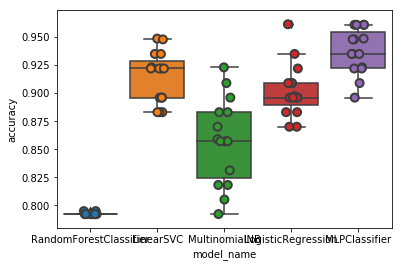

In [40]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    MLPClassifier(hidden_layer_sizes=(64,32,8), activation='relu', solver='adam', max_iter=500),
]
CV = 15
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# Printing the Accuracy of all the 5 Models 

In [41]:
print(cv_df.groupby('model_name').accuracy.mean() * 100)

model_name
LinearSVC                 91.439671
LogisticRegression        90.228660
MLPClassifier             93.777334
MultinomialNB             85.733156
RandomForestClassifier    79.256299
Name: accuracy, dtype: float64


# So "MLPClassifier" Model have highest Accuracy ~ ~ 94 %

Now It's time to work on the test data and to predict the "Patient_Tag" for the test data

In [42]:
test_data = pd.read_csv('test.csv',encoding= 'unicode_escape')
test_data

,Index,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT
0,1,BLOG,uhmagonline.com,http://uhmagonline.com/son-of-the-late-kimbo-s...,7/30/2016,00:41:23,NaN,NaN,"Baby Slice, the son of the late Kimbo Slice, h..."
1,2,FORUMS,implantinformationnetwork.yuku.com,http://implantinformationnetwork.yuku.com/topi...,6/20/2016,00:07:30,6/20/2016 9:37,My Story --,"<p><font face=""sans-serif"" size=""3"">I have had..."
2,3,BLOG,http://cestlapharm.blogspot.com,http://cestlapharm.blogspot.com/2016/06/us-fda...,6/15/2016,15:44:00,6/16/2016 1:14,US FDA ?????canagliflozin?dapagliflozin?????????,"Previously, sodium-glucose cotransporter-2 (SG..."
3,4,FORUMS,healthboards.com,http://www.healthboards.com/boards/heart-disor...,7/17/2016,19:41:00,NaN,NaN,Hello. I suffer from congestive heart failure ...
4,5,BLOG,http://www.sciencecodex.com,http://www.sciencecodex.com/vitamin_d_improves...,04-04-2016,15:30:45,04-05-2016 01:00,"Vitamin D improves heart function, study finds",A daily dose of vitamin D3 improves heart func...
5,6,Facebook,NaN,http://facebook.com/55779104577_10154506997494578,04-04-2016,12:04 PM,04-04-2016 12:04,NaN,"""reuters.com A stem cell therapy developed by ..."
6,7,FORUMS,foros.internautas.org,http://foros.internautas.org/viewtopic.php?t=4...,4/28/2016,21:19:00,4/29/2016 6:49,TODO SOBRE GSM,"Sorry, I ran out of credit http://www.buffaloi..."
7,8,FORUMS,icdsupportgroup.org,http://www.icdsupportgroup.org/board/viewtopic...,7/20/2016,07:15:00,NaN,NaN,The sun will come out tomorrow....But for peop...
8,9,BLOG,http://human-diagrams.blogspot.com,http://human-diagrams.blogspot.com/2016/06/pat...,6/15/2016,06:14:00,6/15/2016 15:44,Pathophysiology of Heart failure,Pathophysiology of Heart failure
9,10,BLOG,http://zandcell.livejournal.com,http://zandcell.livejournal.com/572028.html,04-04-2016,13:26:29,04-04-2016 22:56,Vericel stem cell therapy cuts heart failure d...,( http://blog.zandcell.com/vericel-stem-cell-t...


There was an error in one of the row of the test data which created a new column "Unnamed 9". This error I removed in excel manually. 
Now test data is fine.

In [43]:
test_data.isnull().sum()

Index                0
Source               0
Host                30
Link                 0
Date(ET)             0
Time(ET)             0
time(GMT)           91
Title              117
TRANS_CONV_TEXT      0
dtype: int64

Test data contains the null values in 3 columns i.e. "Host", "time(GMT)" and "Title".

Now perform same steps to create the date time columns/features in test data.

In [44]:
for i in range(0,571):
    if ('/' in test_data['Date(ET)'][i]):
        test_data['Date(ET)'][i] = pd.to_datetime(test_data['Date(ET)'][i], format='%m/%d/%Y')
    elif(('-' in test_data['Date(ET)'][i]) and (('Jan' in test_data['Date(ET)'][i]) or ('Feb' in test_data['Date(ET)'][i]) or ('Mar' in test_data['Date(ET)'][i]) or ('Apr' in test_data['Date(ET)'][i]) or ('May' in test_data['Date(ET)'][i]) or ('Jun' in test_data['Date(ET)'][i]) or ('Jul' in test_data['Date(ET)'][i]) or ('Aug' in test_data['Date(ET)'][i]) or ('Sep' in test_data['Date(ET)'][i]) or ('Oct' in test_data['Date(ET)'][i]) or ('Nov' in test_data['Date(ET)'][i]) or ('Dec' in test_data['Date(ET)'][i]))):
        test_data['Date(ET)'][i] = pd.to_datetime(test_data['Date(ET)'][i], format='%d-%b-%y')
    else:
        test_data['Date(ET)'][i] = pd.to_datetime(test_data['Date(ET)'][i], format='%d-%m-%Y')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [45]:
for i in range(0,571):
    if (('AM' in test_data['Time(ET)'][i]) or ('PM' in test_data['Time(ET)'][i])):
        test_data['Time(ET)'][i] = pd.to_datetime(test_data['Time(ET)'][i], format='%I:%M %p')
    elif('.' in test_data['Time(ET)'][i]):
        test_data['Time(ET)'][i] = pd.to_datetime('0:0:0', format='%H:%M:%S')
    else:
        test_data['Time(ET)'][i] = pd.to_datetime(test_data['Time(ET)'][i], format='%H:%M:%S')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [46]:
test_data.head()

,Index,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT
0,1,BLOG,uhmagonline.com,http://uhmagonline.com/son-of-the-late-kimbo-s...,2016-07-30 00:00:00,1900-01-01 00:41:23,NaN,NaN,"Baby Slice, the son of the late Kimbo Slice, h..."
1,2,FORUMS,implantinformationnetwork.yuku.com,http://implantinformationnetwork.yuku.com/topi...,2016-06-20 00:00:00,1900-01-01 00:07:30,6/20/2016 9:37,My Story --,"<p><font face=""sans-serif"" size=""3"">I have had..."
2,3,BLOG,http://cestlapharm.blogspot.com,http://cestlapharm.blogspot.com/2016/06/us-fda...,2016-06-15 00:00:00,1900-01-01 15:44:00,6/16/2016 1:14,US FDA ?????canagliflozin?dapagliflozin?????????,"Previously, sodium-glucose cotransporter-2 (SG..."
3,4,FORUMS,healthboards.com,http://www.healthboards.com/boards/heart-disor...,2016-07-17 00:00:00,1900-01-01 19:41:00,NaN,NaN,Hello. I suffer from congestive heart failure ...
4,5,BLOG,http://www.sciencecodex.com,http://www.sciencecodex.com/vitamin_d_improves...,2016-04-04 00:00:00,1900-01-01 15:30:45,04-05-2016 01:00,"Vitamin D improves heart function, study finds",A daily dose of vitamin D3 improves heart func...


In [47]:
test_data['Date_Time_ET'] = np.nan
for i in range(0,571):
    a , b = str(test_data['Date(ET)'][i]).split(' ')
    c , d = str(test_data['Time(ET)'][i]).split(' ')
    test_data['Date_Time_ET'][i] = pd.to_datetime(a + ' ' + d , format='%Y-%m-%d %H:%M:%S')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [48]:
test_data['Date_Time_GMT'] = np.nan
for i in range(0,571):
    
    Time_ET = pd.Timestamp(str(test_data['Date_Time_ET'][i]), tz='US/Eastern')

    test_data['Date_Time_GMT'][i] = Time_ET.tz_convert('UTC') 

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
test_data = test_data.drop(['Date(ET)', 'Time(ET)', 'time(GMT)'], axis =  1)

In [50]:
test_data['Date_Time_ET_day'] = pd.DatetimeIndex(test_data['Date_Time_ET']).day
test_data['Date_Time_ET_month'] = pd.DatetimeIndex(test_data['Date_Time_ET']).month
test_data['Date_Time_ET_hour'] = pd.DatetimeIndex(test_data['Date_Time_ET']).hour
test_data['Date_Time_ET_minute'] = pd.DatetimeIndex(test_data['Date_Time_ET']).minute
test_data['Date_Time_ET_second'] = pd.DatetimeIndex(test_data['Date_Time_ET']).second
test_data['Date_Time_ET_dayofweek'] = pd.DatetimeIndex(test_data['Date_Time_ET']).dayofweek

In [51]:
test_data['Date_Time_GMT_day'] = pd.DatetimeIndex(test_data['Date_Time_GMT']).day
test_data['Date_Time_GMT_month'] = pd.DatetimeIndex(test_data['Date_Time_GMT']).month
test_data['Date_Time_GMT_hour'] = pd.DatetimeIndex(test_data['Date_Time_GMT']).hour
test_data['Date_Time_GMT_minute'] = pd.DatetimeIndex(test_data['Date_Time_GMT']).minute
test_data['Date_Time_GMT_second'] = pd.DatetimeIndex(test_data['Date_Time_GMT']).second
test_data['Date_Time_GMT_dayofweek'] = pd.DatetimeIndex(test_data['Date_Time_GMT']).dayofweek

In [52]:
test_data = test_data.drop(['Date_Time_ET', 'Date_Time_GMT'], axis =  1)

In [53]:
test_data = test_data.drop(['Host'], axis =  1)

In [54]:
test_data.head()

,Index,Source,Link,Title,TRANS_CONV_TEXT,Date_Time_ET_day,Date_Time_ET_month,Date_Time_ET_hour,Date_Time_ET_minute,Date_Time_ET_second,Date_Time_ET_dayofweek,Date_Time_GMT_day,Date_Time_GMT_month,Date_Time_GMT_hour,Date_Time_GMT_minute,Date_Time_GMT_second,Date_Time_GMT_dayofweek
0,1,BLOG,http://uhmagonline.com/son-of-the-late-kimbo-s...,NaN,"Baby Slice, the son of the late Kimbo Slice, h...",30,7,0,41,23,5,30,7,4,41,23,5
1,2,FORUMS,http://implantinformationnetwork.yuku.com/topi...,My Story --,"<p><font face=""sans-serif"" size=""3"">I have had...",20,6,0,7,30,0,20,6,4,7,30,0
2,3,BLOG,http://cestlapharm.blogspot.com/2016/06/us-fda...,US FDA ?????canagliflozin?dapagliflozin?????????,"Previously, sodium-glucose cotransporter-2 (SG...",15,6,15,44,0,2,15,6,19,44,0,2
3,4,FORUMS,http://www.healthboards.com/boards/heart-disor...,NaN,Hello. I suffer from congestive heart failure ...,17,7,19,41,0,6,17,7,23,41,0,6
4,5,BLOG,http://www.sciencecodex.com/vitamin_d_improves...,"Vitamin D improves heart function, study finds",A daily dose of vitamin D3 improves heart func...,4,4,15,30,45,0,4,4,19,30,45,0


In [55]:
test_data['Source'].unique()

array(['BLOG', 'FORUMS', 'Facebook', 'YOUTUBE', 'FACEBOOK'], dtype=object)

In [56]:
test_data['Source'] = test_data['Source'].replace(['FORUMS', 'BLOG', 'YOUTUBE', 'FACEBOOK', 'Facebook'],[0,1,2,3,3])

In [57]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 17 columns):
Index                      571 non-null int64
Source                     571 non-null int64
Link                       571 non-null object
Title                      454 non-null object
TRANS_CONV_TEXT            571 non-null object
Date_Time_ET_day           571 non-null int64
Date_Time_ET_month         571 non-null int64
Date_Time_ET_hour          571 non-null int64
Date_Time_ET_minute        571 non-null int64
Date_Time_ET_second        571 non-null int64
Date_Time_ET_dayofweek     571 non-null int64
Date_Time_GMT_day          571 non-null int64
Date_Time_GMT_month        571 non-null int64
Date_Time_GMT_hour         571 non-null int64
Date_Time_GMT_minute       571 non-null int64
Date_Time_GMT_second       571 non-null int64
Date_Time_GMT_dayofweek    571 non-null int64
dtypes: int64(14), object(3)
memory usage: 75.9+ KB


So "Title" is the only column with null values and here we can not use "Patient_Tag" as we have used it in train data. And imputation with "forward fill" or "backward fill" will create more noise so I will use '0' to impute the null values of the "Title" column. 

In [58]:
test_data['Title'] = test_data['Title'].fillna('0')

test_data

In [101]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features_1_for_test = np.array(test_data['Source']).reshape(571,1)
features_2_for_test = np.array(test_data['Date_Time_ET_day']).reshape(571,1)
features_3_for_test = np.array(test_data['Date_Time_ET_month']).reshape(571,1)
features_4_for_test = np.array(test_data['Date_Time_ET_hour']).reshape(571,1)
features_5_for_test = np.array(test_data['Date_Time_ET_minute']).reshape(571,1)
features_6_for_test = np.array(test_data['Date_Time_ET_second']).reshape(571,1)
features_7_for_test = np.array(test_data['Date_Time_ET_dayofweek']).reshape(571,1)
features_8_for_test = np.array(test_data['Date_Time_GMT_day']).reshape(571,1)
features_9_for_test = np.array(test_data['Date_Time_GMT_month']).reshape(571,1)
features_10_for_test = np.array(test_data['Date_Time_GMT_hour']).reshape(571,1)
features_11_for_test = np.array(test_data['Date_Time_GMT_minute']).reshape(571,1)
features_12_for_test = np.array(test_data['Date_Time_GMT_second']).reshape(571,1)
features_13_for_test = np.array(test_data['Date_Time_GMT_dayofweek']).reshape(571,1)
features_14_for_test = tfidf.fit_transform(test_data.Link).toarray()
features_15_for_test = tfidf.fit_transform(test_data.Title).toarray()
features_16_for_test = tfidf.fit_transform(test_data.TRANS_CONV_TEXT).toarray()
features_for_test = np.concatenate((features_1_for_test,features_2_for_test,features_3_for_test,features_4_for_test,features_5_for_test,features_6_for_test,features_7_for_test,features_8_for_test,features_9_for_test,features_10_for_test,features_11_for_test,features_12_for_test,features_13_for_test,features_14_for_test,features_15_for_test,features_16_for_test),axis=1)
features_for_test.shape

(571, 3629)

So here the feature matrix have size less than the feature matrix we get from the training data. 

And it is because we have imputed the 1 lenth string i.e. '0' in place of null values and which created less features.

So we can add some all zeros column in this matrix to make it complete so that it can be used to predict "Patient_Tag" for test data and feed into the trained model. 

In [102]:
features.shape

(1157, 7251)

In [103]:
features_for_test.shape

(571, 3629)

In [104]:
# Since Size of features and features_for_test are different
a = np.zeros([571, (features.shape[1]-features_for_test.shape[1])], dtype = int)
features_for_test = np.concatenate((features_for_test, a), axis=1)

In [105]:
features_for_test.shape

(571, 7251)

So now the shape of feature matrix for test data is of same size is it is for feature matrix of train data. And also addng zeroes doesn't add much noise to the test data. 

Now as MLP Classifier gives the best accuracy so we choose it for prediction. 

In [106]:
clf = MLPClassifier(hidden_layer_sizes=(64,32,8), activation='relu', solver='adam', max_iter=500).fit(features, labels)

In [107]:
prediction = clf.predict(features_for_test).reshape(571,1)

In [108]:
prediction

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
    